<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Preprocess_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Preprocess_images**

In [1]:
from PIL import Image
import os
import time
from IPython.display import display
import numpy as np
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image



#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#**ヒストグラム平坦化**

In [2]:
import sys
import cv2
from google.colab.patches import cv2_imshow


path =  "/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_2_img/img00265140_00_1R.png"

def show_histogram(img):
    hist = cv2.calcHist([img],[2],None,[256],[0,256]) 
    plt.plot(hist,color = "b")
    plt.show()

# 適用的ヒストグラム平坦化　CLAHEを定義
clahe1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
clahe4 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
clahe8 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe16 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
clahe32 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))


#ここから
src = cv2.imread(path)
src_yuv = cv2.cvtColor(src, cv2.COLOR_BGR2YUV)

#RGBに分解
src_r = src[:,:,2]
src_g = src[:,:,1]
src_b = src[:,:,0]

# ヒストグラム平坦化
dst_r = cv2.equalizeHist(src_r) # グレイスケールしか使えない
dst_g = cv2.equalizeHist(src_g) # グレイスケールしか使えない
dst_b = cv2.equalizeHist(src_b) # グレイスケールしか使えない
dst = cv2.merge((dst_b,dst_g,dst_r))

# 適用的ヒストグラム平坦化(4x4)
cl0_r = clahe4.apply(src_r)
cl0_g = clahe4.apply(src_g)
cl0_b = clahe4.apply(src_b)
cl0 = cv2.merge((cl0_b,cl0_g,cl0_r))

# 適用的ヒストグラム平坦化(8x8)
cl1_r = clahe8.apply(src_r)
cl1_g = clahe8.apply(src_g)
cl1_b = clahe8.apply(src_b)
cl1 = cv2.merge((cl1_b,cl1_g,cl1_r))

# 適用的ヒストグラム平坦化(16x16)
cl2_r = clahe16.apply(src_r)
cl2_g = clahe16.apply(src_g)
cl2_b = clahe16.apply(src_b)
cl2 = cv2.merge((cl2_b,cl2_g,cl2_r))

# 適用的ヒストグラム平坦化(32x32)
cl3_r = clahe32.apply(src_r)
cl3_g = clahe32.apply(src_g)
cl3_b = clahe32.apply(src_b)
cl3 = cv2.merge((cl3_b,cl3_g,cl3_r))

# ３色同時に調整（4x4)
cl0_yuv = src_yuv.copy()
cl0_yuv[:,:,0] = clahe4.apply(cl0_yuv[:,:,0])
cl0_yuv = cv2.cvtColor(cl0_yuv, cv2.COLOR_YUV2BGR)

# ３色同時に調整（8x8)
cl1_yuv = src_yuv.copy()
cl1_yuv[:,:,0] = clahe8.apply(cl1_yuv[:,:,0])
cl1_yuv = cv2.cvtColor(cl1_yuv, cv2.COLOR_YUV2BGR)

# ３色同時に調整（16x16)
cl2_yuv = src_yuv.copy()
cl2_yuv[:,:,0] = clahe16.apply(cl2_yuv[:,:,0])
cl2_yuv = cv2.cvtColor(cl2_yuv, cv2.COLOR_YUV2BGR)

# ３色同時に調整（32x32)
cl3_yuv = src_yuv.copy()
cl3_yuv[:,:,0] = clahe32.apply(cl3_yuv[:,:,0])
cl3_yuv = cv2.cvtColor(cl3_yuv, cv2.COLOR_YUV2BGR)


# 画像表示
print("orig")
cv2_imshow(src)
print("equalized")
cv2_imshow(dst)
print("clahe4")
cv2_imshow(cl0)
print("clahe8")
cv2_imshow(cl1)
print("clahe16")
cv2_imshow(cl2)
print("clahe32")
cv2_imshow(cl3)
print("clahe4_yuv")
cv2_imshow(cl0_yuv)
print("clahe8_yuv")
cv2_imshow(cl1_yuv)
print("clahe16_yuv")
cv2_imshow(cl2_yuv)
print("clahe32_yuv")
cv2_imshow(cl3_yuv)






orig


NameError: ignored

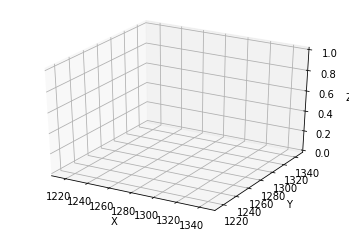

In [4]:
#輝度の3次元グラフを描く
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image


%matplotlib inline

path =  "/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_2_img/img00265140_00_1R.png"
#画像の読み込み

 
src = Image.open(path)
src_gray = src.convert("L").copy()  # グレースケール変換
src_gray= np.asarray(src_gray)

#x = np.arange(0, src.size[0], 1)
#y = np.arange(0, src.size[1], 1)

x = np.arange(-2, 2, 0.05) # x点として[-2, 2]まで0.05刻みでサンプル
y = np.arange(-2, 2, 0.05)  # y点として[-2, 2]まで0.05刻みでサンプル
x, y = np.meshgrid(src.size[0], src.size[1])
#z = img_gray.reshape(-1)
z = np.exp(-(x**2 + y**2))


#3D Figure作成
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim(0.0,1.0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot_wireframe(x, y, z, color='blue',linewidth=0.3) # ワイヤーフレームのプロット。linewidthは曲面のメッシュの線の太さ，をそれぞれ表す。

plt.show() # 絵の出力。



0

#**224pxに縮小して保存（Image.BILINEAR）**

In [ ]:
path = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
ext = 'png'  #png or jpg

os.chdir(path)


#元画像フォルダ
in_path = ['cropped_2_img', 'disc_2_img', 'macula_2_img', 'vascular_2_img']

#保存先フォルダ
out_path = ['cropped_224_img', 'disc_224_img', 'macula_224_img', 'vascular_224_img']


In [ ]:
start_time = time.time()
process = [1]

for i in process:
    #保存先フォルダの作成
    if os.path.exists(out_path[i]):
        shutil.rmtree(out_path[i])
    os.makedirs(out_path[i])

    k=0
    for j in os.listdir(in_path[i]):
        path = os.path.join(in_path[i], str(j))
        print(path)
        pilr_img = Image.open(path).convert('RGB')
        converted_img = pilr_img.resize((224, 224), Image.BILINEAR)
        converted_img.save(os.path.join(out_path[i], str(j)))
        print(str(k)+' images converted!')
        k+=1
    
    
    # calculate elapsed time
    elapsed_time = int(time.time() - start_time)

    # convert second to hour, minute and seconds
    elapsed_hour = elapsed_time // 3600
    elapsed_minute = (elapsed_time % 3600) // 60
    elapsed_second = (elapsed_time % 3600 % 60)

    # print as 00:00:00
    print(str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2))


#**Split dataset for crossvalidation**

In [ ]:
def get_path(orig_path, dst_path, split_num):
    #データの分割数を設定
    data_list = [0]
    k=0
    data_list = glob.glob(orig_path+'/*')
    split_length = int(len(data_list)/split_num)
    return data_list, split_length

def makefolder(dst_path):
    #フォルダを作成
    if os.path.exists(dst_path): #もしすでにフォルダがあれば削除
        shutil.rmtree(dst_path)
    os.mkdir(dst_path)  # 作成したいフォルダ名を作成
    for i in range(split_num):
        os.mkdir(dst_path+'/'+str(i))
        os.mkdir(dst_path+'/'+str(i)+'/train')
        os.mkdir(dst_path+'/'+str(i)+'/val')

def split_data_list(data_list, split_num):
    split_data, dst_data, dst_train, dst_val, dst_test = [0]*split_num, [0]*split_num, [0]*split_num, [0]*split_num, [0]*split_num

    #データの分割
    split_data = list(np.array_split(data_list, split_num))

    #データセット全体と分割したデータの差分を取り、dst_dataに格納

    dst_data = [0] * split_num
    for i in range(split_num):
        dst_data[i] = [x for x in data_list if x not in split_data[i]]

    #トレーニングセット、バリデーションセット、テストセットのリスト作成
    for i in range(split_num):
        dst_train[i] = dst_data[i]
        dst_val[i] = split_data[i]  #テストセット
    
    return dst_train, dst_val

def copy_to_folders(split_num,  dst_train, dst_val, dst_path):
    k=0
    for i in range(split_num):
        dst_path_train = dst_path +'/'+str(i)+'/train'
        dst_path_val = dst_path +'/'+str(i)+'/val'
        for p in dst_train[k]:  # 選択したファイルを目的フォルダにコピー
            shutil.copy(p, dst_path_train)
            #print(p)
            print(dst_path_train)

        for p in dst_val[k]:  # 選択したファイルを目的フォルダにコピー
            shutil.copy(p, dst_path_val)
            #print(p)    
            print(dst_path_val)

        k+=1

In [ ]:
out_list = ["cropped_224", "disc_224", "macula_224", "vascular_224"]

for i in out_list:
    orig_path = "/content/drive/MyDrive/Deep_learning/FundusPhoto/"+str(i)+"_img"
    dst_path = "/content/drive/MyDrive/Deep_learning/FundusPhoto/"+str(i)+"_img_trainval"  # フォルダ名
    split_num = 5  #データをいくつに分割するかを記載

    data_list, split_length = get_path(orig_path, dst_path, split_num)
    makefolder(dst_path)

    dst_train, dst_val = split_data_list(data_list, split_num)
    copy_to_folders(split_num, dst_train, dst_val, dst_path)